In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os, gc, re, warnings
warnings.filterwarnings("ignore")

In [4]:
dftr = pd.read_csv("/content/drive/MyDrive/merged_data.csv")
dftr = dftr.dropna()
dftr = dftr.reset_index(drop=True)
dftr

Text  Category
0      बिहार मे होबय वाला नगर निगम \nचुनाव 2022 के नव...  Politics
1      राज्य मे भूमि सँ जुड़ल भ्रष्टाचार \nकेर मामिला ...  Politics
2      गांधीनगर | राष्ट्रीय एकता दिवस पर \nसोम दिन गु...  Politics
3      गुजरात केर मोरबी मे रवि दिन सांझ भेल दर्दनाक द...  Politics
4      गुजरातक मोरबी\nकेर उक्त झुलैत पुल \nलगभग 150 स...  Politics
...                                                  ...       ...
15465  । मांस काठमांडू।नेपालगुंज में लक्ष्मी अंतरसंचा...   Economy
15466  । ३१ जुलाई काठमाण्डू।टाटा मोटर्स के आधिकारिक व...   Economy
15467  । १३ अप्रैल काठमाण्डू।कोरियाई मोटर्स कंपनी ग्र...   Economy
15468  । आसंजन काठमाण्डू।स्पोर्ट्स हैचबैक तसेया त्याट...   Economy
15469  । ३ काठमाण्डू।आईएमएस मोटर्स काठमांडू के बैंक म...   Economy

[15470 rows x 2 columns]

In [5]:
dftr['Category'].value_counts()

Culture          3192
Literature       2758
Politics         2594
Sports           2210
Entertainment    1078
Opinion           992
EduTech           784
Economy           693
Health            636
Interview         533
Name: Category, dtype: int64

In [6]:
dftr.Text = dftr.Text.astype(str)

In [ ]:
! pip install transformers -q

     |████████████████████████████████| 5.5 MB 15.1 MB/s 
     |████████████████████████████████| 182 kB 67.1 MB/s 
     |████████████████████████████████| 7.6 MB 54.7 MB/s 


In [7]:
from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [8]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [9]:
BATCH_SIZE = 16

class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"Text"]
        tokens = tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=MAX_LEN,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

ds_tr = EmbedDataset(dftr)     # <-----------------------------------------> mind your head
#ds_tr = EmbedDataset(train)  # for emoji makes sense
embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr,\
                        batch_size=BATCH_SIZE,\
                        shuffle=False)

In [10]:
tokenizer = None
MAX_LEN = 640

def get_embeddings(MODEL_NM='', MAX=640, BATCH_SIZE=4, verbose=True):
    global tokenizer, MAX_LEN
    DEVICE="cuda"
    model = AutoModel.from_pretrained( MODEL_NM,from_tf=True )   #TRue for TF.h5 model
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )
    MAX_LEN = MAX

    model = model.to(DEVICE)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        #sentence_embeddings = max_pooling(model_output, attention_mask.detach().cpu())    #max pooling
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
        all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)
    if verbose:
        print('Train embeddings shape',all_train_text_feats.shape)

    return all_train_text_feats

In [11]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [12]:
MODEL_NM = 'NepBERTa/NepBERTa'
all_train_text_feats = get_embeddings(MODEL_NM, MAX=512)

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/534M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertModel.

All the weights of BertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


vocab.txt:   0%|          | 0.00/547k [00:00<?, ?B/s]

100%|██████████| 967/967 [17:21<00:00,  1.08s/it]


Train embeddings shape (15470, 768)


In [13]:
all_train_text_feats.shape

(15470, 768)

In [ ]:
#all_train_text_feats[12999]

-0.028025214

In [16]:
len(all_train_text_feats)
X_train = all_train_text_feats

In [18]:
X_train.shape

(15470, 768)

In [17]:
del all_train_text_feats

In [15]:
y_train  = dftr['Category']
y_train.shape

(15470,)

In [19]:
#y_train = y_train[:12240]
#y_train.shape

In [20]:
Y_train = y_train
del y_train

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

In [22]:
x_train.shape, y_train.shape

((12376, 768), (12376,))

In [23]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
clf=LinearSVC(penalty='l2')
clf.fit(x_train, y_train)    # training model on train data

clfval = clf.predict(x_test)   # predicting test data
print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))  # printing F1 score


F1 Score : 0.7307692307692306


In [24]:
from sklearn.svm import SVC

clf=SVC(kernel='rbf',gamma = 15,degree = 3, random_state=0)
clf.fit(x_train, y_train)    # training model on train data

clfval = clf.predict(x_test)   # predicting test data
print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))  # printing F1 score


F1 Score : 0.7960568842921784


In [25]:
from sklearn.linear_model import LogisticRegression
lrr=LogisticRegression(solver='saga', n_jobs=1, C=1e5)
lrr.fit(x_train, y_train)
lrrval = lrr.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, lrrval, average='micro')))

F1 Score : 0.7773109243697479


In [26]:
from sklearn.linear_model import Perceptron

percept = Perceptron(alpha=1000, tol=1e-6, penalty='l2', random_state=1, max_iter=3000)
percept = percept.fit(x_train, y_train)

cpfval = percept.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, cpfval, average='micro')))

F1 Score : 0.04880413703943116


In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=2,max_features='sqrt',class_weight='balanced')
clf.fit(x_train, y_train)

pred=clf.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, pred, average='micro')))

F1 Score : 0.7020038784744667


In [28]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators = 150,learning_rate=0.5)
model.fit(x_train, y_train)

pred=model.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, pred, average='micro')))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 12376, number of used features: 768
[LightGBM] [Info] Start training from score -1.586355
[LightGBM] [Info] Start training from score -3.128248
[LightGBM] [Info] Start training from score -2.985763
[LightGBM] [Info] Start training from score -2.673583
[LightGBM] [Info] Start training from score -3.158213
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -1.743339
[LightGBM] [Info] Start training from score -2.722783
[LightGBM] [Info] Start training from score -1.783391
[LightGBM] [Info] Start training from score -1.930197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

               precision    recall  f1-score   support

      Culture       0.28      0.80      0.42       659
      Economy       0.36      0.33      0.34       151
      EduTech       0.20      0.03      0.04       159
Entertainment       0.25      0.41      0.31       224
       Health       0.09      0.05      0.06       110
    Interview       0.12      0.08      0.09        91
   Literature       0.28      0.01      0.02       593
      Opinion       0.24      0.10      0.14       179
     Politics       0.59      0.24      0.34       514
       Sports       0.47      0.33      0.39       414

     accuracy                           0.31      3094
    macro avg       0.29      0.24      0.22      3094
 weighted avg       0.34      0.31      0.26      3094



<Axes: >

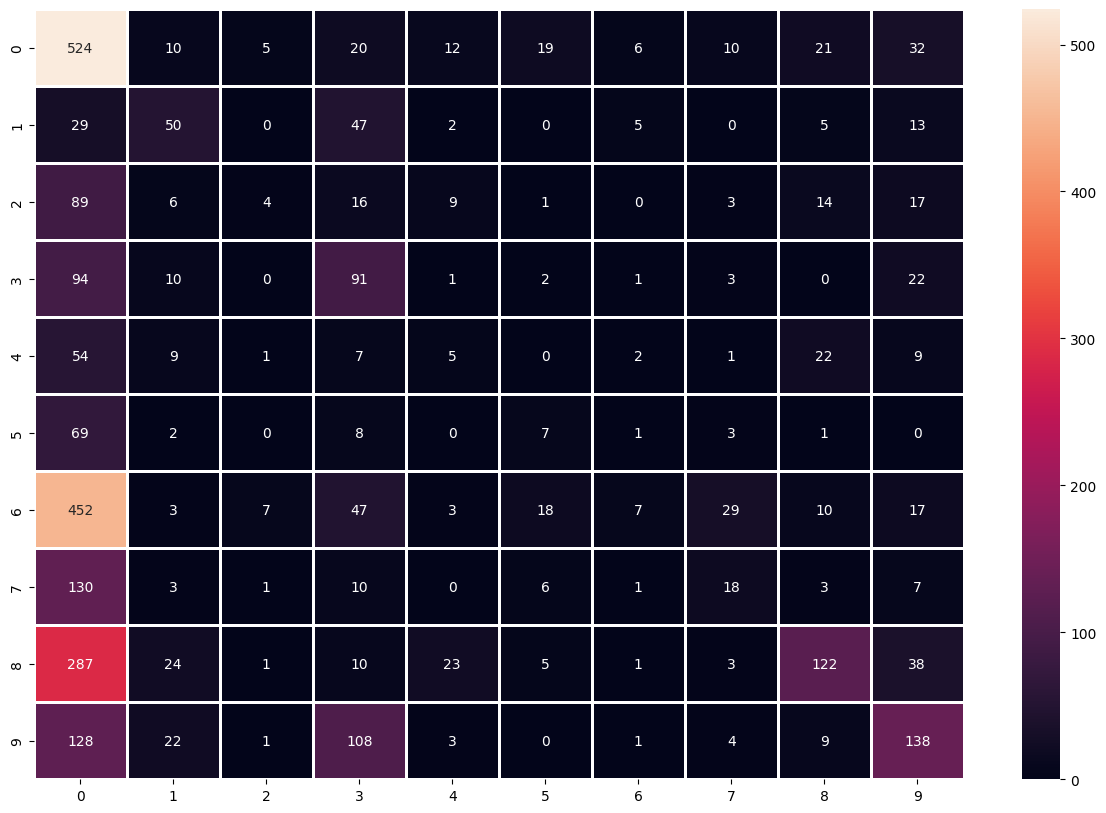

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
import matplotlib.pyplot as plt
#countvector
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

In [30]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf',gamma = 10,C = 10, random_state=42)
clf.fit(x_train, y_train)    # training model on train data

clfval = clf.predict(x_test)   # predicting test data
print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))  # printing F1 score

F1 Score : 0.8093083387201034


               precision    recall  f1-score   support

      Culture       0.79      0.78      0.78       659
      Economy       0.83      0.90      0.86       151
      EduTech       0.56      0.48      0.52       159
Entertainment       0.81      0.72      0.76       224
       Health       0.75      0.71      0.73       110
    Interview       0.90      0.80      0.85        91
   Literature       0.80      0.82      0.81       593
      Opinion       0.87      0.80      0.84       179
     Politics       0.86      0.89      0.88       514
       Sports       0.84      0.91      0.88       414

     accuracy                           0.81      3094
    macro avg       0.80      0.78      0.79      3094
 weighted avg       0.81      0.81      0.81      3094



<Axes: >

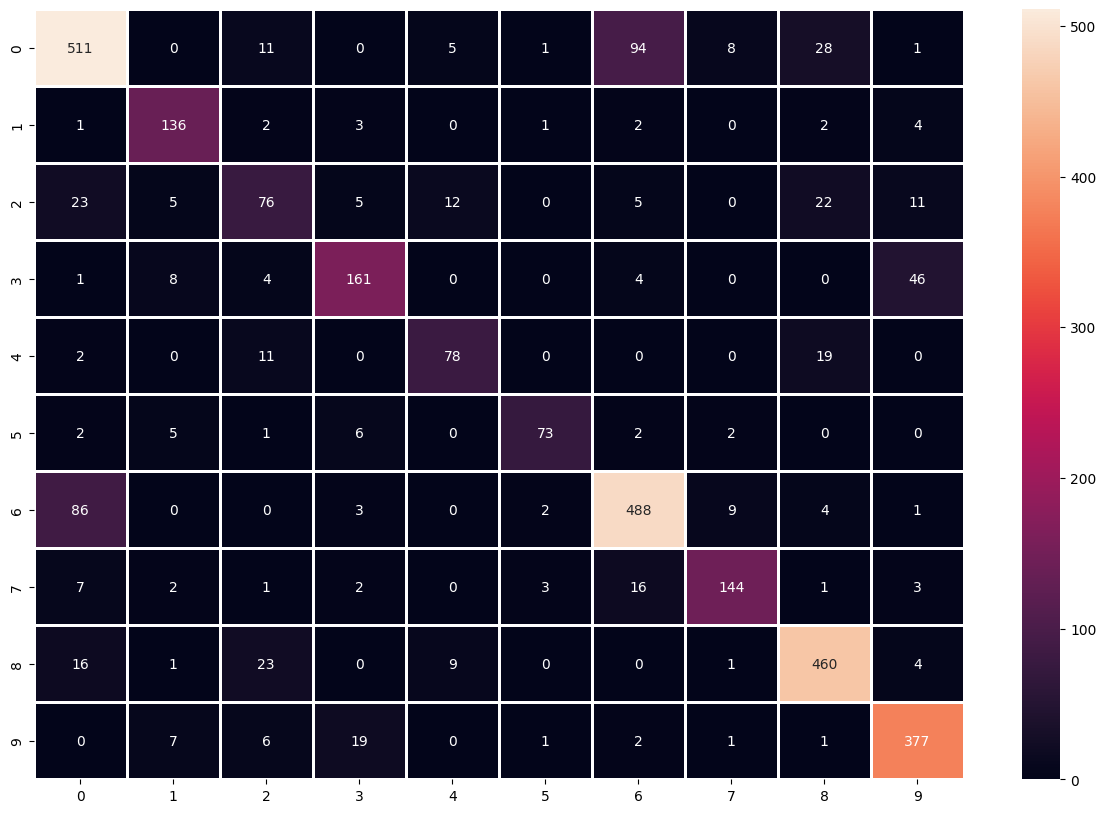

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clfval))
import matplotlib.pyplot as plt
#countvector
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, clfval)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

In [32]:
from sklearn.model_selection import KFold

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

f1 = []

for train_index, test_index in kfold.split(X_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=SVC(kernel='rbf',gamma = 10,C = 10, random_state=42)
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.8093083387201034
               precision    recall  f1-score   support

      Culture       0.79      0.78      0.78       659
      Economy       0.83      0.90      0.86       151
      EduTech       0.56      0.48      0.52       159
Entertainment       0.81      0.72      0.76       224
       Health       0.75      0.71      0.73       110
    Interview       0.90      0.80      0.85        91
   Literature       0.80      0.82      0.81       593
      Opinion       0.87      0.80      0.84       179
     Politics       0.86      0.89      0.88       514
       Sports       0.84      0.91      0.88       414

     accuracy                           0.81      3094
    macro avg       0.80      0.78      0.79      3094
 weighted avg       0.81      0.81      0.81      3094

F1 Score : 0.826115061409179
               precision    recall  f1-score   support

      Culture       0.79      0.84      0.81       637
      Economy       0.77      0.80      0.78       137
  

In [34]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf',gamma = 10,C = 10, random_state=42)
clf.fit(x_train, y_train)    # training model on train data

clfval = clf.predict(x_test)   # predicting test data
print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))  # printing F1 score

F1 Score : 0.8112475759534583


In [35]:
from sklearn.linear_model import LogisticRegression
lrr=LogisticRegression(solver='saga', n_jobs=1, C=1e5)
lrr.fit(x_train, y_train)
lrrval = lrr.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, lrrval, average='micro')))

F1 Score : 0.779896574014221


In [36]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

f1 = []

for train_index, test_index in kfold.split(X_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=LogisticRegression(solver='saga', n_jobs=1, C=1e5)
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.7776341305753071
               precision    recall  f1-score   support

      Culture       0.76      0.74      0.75       659
      Economy       0.81      0.85      0.83       151
      EduTech       0.51      0.40      0.45       159
Entertainment       0.76      0.75      0.76       224
       Health       0.71      0.67      0.69       110
    Interview       0.78      0.74      0.76        91
   Literature       0.76      0.80      0.78       593
      Opinion       0.76      0.73      0.75       179
     Politics       0.86      0.89      0.87       514
       Sports       0.83      0.86      0.84       414

     accuracy                           0.78      3094
    macro avg       0.75      0.74      0.75      3094
 weighted avg       0.77      0.78      0.78      3094

F1 Score : 0.8002585649644475
               precision    recall  f1-score   support

      Culture       0.78      0.80      0.79       637
      Economy       0.73      0.80      0.76       137
 

<Axes: >

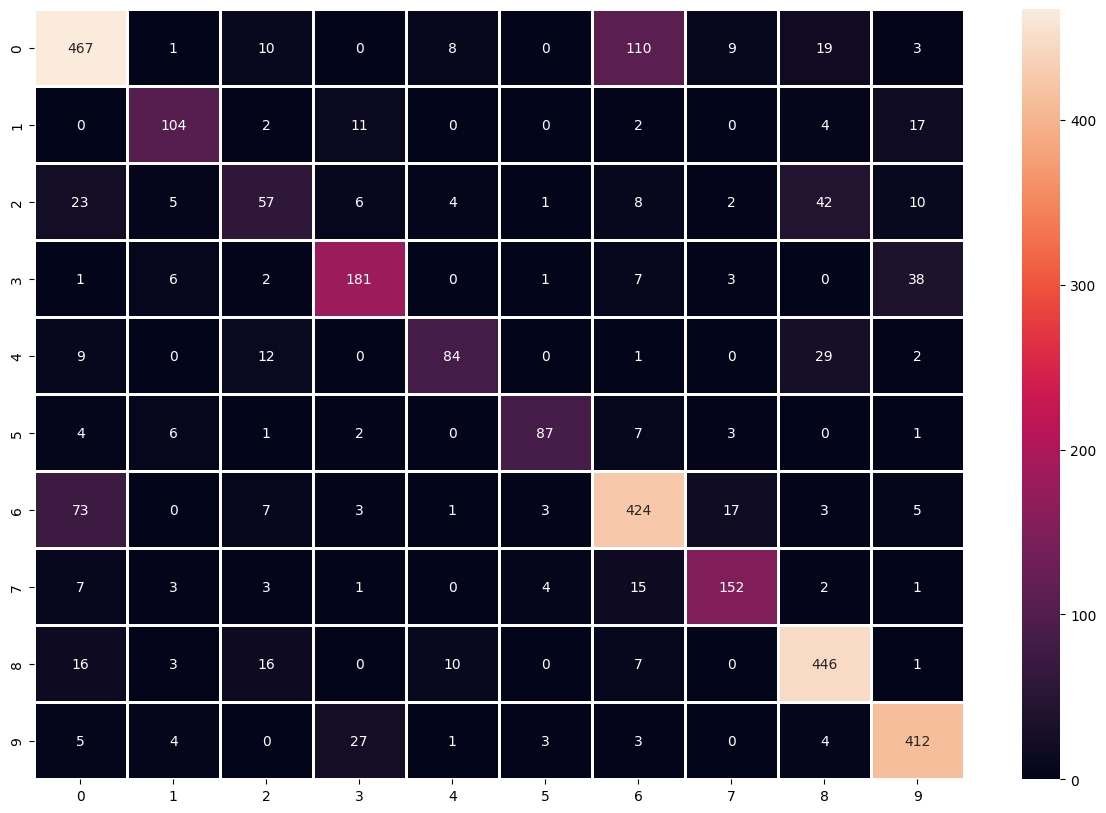

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, clfval)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

In [ ]:
# nepali BERT

In [ ]:
MODEL_NM = 'Shushant/nepaliBERT'
all_train_text_feats = get_embeddings(MODEL_NM, MAX=512)

Downloading:   0%|          | 0.00/589 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at Shushant/nepaliBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Shushant/nepaliBERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You

Downloading:   0%|          | 0.00/529k [00:00<?, ?B/s]

100%|██████████| 1531/1531 [07:06<00:00,  3.59it/s]

Train embeddings shape (13008,)


In [ ]:
X_train = all_train_text_feats[:12240]

X_tr = []
for arr in X_train:
  X_tr.append(arr.reshape(768))

X_train = np.array(X_tr)


(12240, 768)

In [ ]:
Y_train = y_train
X_train.shape, Y_train.shape

((12240, 768), (12240,))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5)

f1 = []

for train_index, test_index in kfold.split(X_train, Y_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=SVC(kernel='rbf',gamma = 10,C = 10, random_state=42)
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.5870098039215687
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       604
           1       0.52      0.97      0.68       809
           2       0.15      0.05      0.08       173
           3       0.64      0.34      0.44       219
           4       0.89      0.56      0.68       234
           5       0.61      0.14      0.22       148
           6       0.58      0.06      0.11       118
           7       0.87      0.34      0.48       143

    accuracy                           0.59      2448
   macro avg       0.62      0.38      0.42      2448
weighted avg       0.61      0.59      0.54      2448

F1 Score : 0.6491013071895425
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       604
           1       0.61      0.98      0.75       809
           2       0.68      0.16      0.25       174
           3       0.62      0.38      0.47       218
           4      

In [ ]:
from sklearn.ensemble import RandomForestClassifier

f1 = []

for train_index, test_index in kfold.split(X_train, Y_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=RandomForestClassifier()
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.6327614379084967
              precision    recall  f1-score   support

           0       0.64      0.73      0.68       604
           1       0.61      0.95      0.74       809
           2       0.12      0.03      0.05       173
           3       0.61      0.47      0.53       219
           4       0.87      0.66      0.75       234
           5       0.50      0.07      0.13       148
           6       0.71      0.08      0.15       118
           7       0.79      0.36      0.50       143

    accuracy                           0.63      2448
   macro avg       0.61      0.42      0.44      2448
weighted avg       0.62      0.63      0.58      2448

F1 Score : 0.6736111111111112
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       604
           1       0.67      0.98      0.80       809
           2       0.62      0.07      0.13       174
           3       0.58      0.49      0.53       218
           4      

In [ ]:
from sklearn.linear_model import LogisticRegression
lrr=LogisticRegression(solver='saga', n_jobs=1, C=1e5)
lrr.fit(x_train, y_train)
lrrval = lrr.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, lrrval, average='micro')))

F1 Score : 0.6907679738562091


In [ ]:
f1 = []

for train_index, test_index in kfold.split(X_train, Y_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=LogisticRegression(solver='saga', n_jobs=1, C=1e5)
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.6895424836601307
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       604
           1       0.86      0.89      0.88       809
           2       0.41      0.51      0.45       173
           3       0.62      0.53      0.57       219
           4       0.84      0.70      0.76       234
           5       0.37      0.33      0.35       148
           6       0.26      0.26      0.26       118
           7       0.70      0.61      0.65       143

    accuracy                           0.69      2448
   macro avg       0.59      0.57      0.58      2448
weighted avg       0.69      0.69      0.69      2448

F1 Score : 0.7258986928104575
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       604
           1       0.90      0.92      0.91       809
           2       0.41      0.38      0.40       174
           3       0.62      0.54      0.57       218
           4      

In [ ]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf',degree = 3, random_state=0,max_iter=10000)
clf.fit(x_train, y_train)    # training model on train data

clfval = clf.predict(x_test)   # predicting test data
print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))  # printing F1 score


F1 Score : 0.6997549019607843


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(x_train, y_train)

pred=model.predict(x_test)
print('F1 Score : {}'.format(f1_score(y_test, pred, average='micro')))

F1 Score : 0.6703431372549019


# deberta base nepali

In [ ]:
MODEL_NM = 'Sakonii/deberta-base-nepali'
all_train_text_feats = get_embeddings(MODEL_NM, MAX=512)

Downloading:   0%|          | 0.00/773 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/557M [00:00<?, ?B/s]

Some weights of the model checkpoint at Sakonii/deberta-base-nepali were not used when initializing DebertaModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/413 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

100%|██████████| 1531/1531 [10:41<00:00,  2.38it/s]

Train embeddings shape (13008,)


In [ ]:
X_train = all_train_text_feats[:12240]

X_tr = []
for arr in X_train:
  X_tr.append(arr.reshape(768))

X_train = np.array(X_tr)

In [ ]:
f1 = []

for train_index, test_index in kfold.split(X_train, Y_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=SVC(kernel='rbf',gamma = 10,C = 10, random_state=42)
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.6429738562091504
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       604
           1       0.67      0.93      0.78       809
           2       0.24      0.17      0.20       173
           3       0.69      0.58      0.63       219
           4       0.87      0.53      0.66       234
           5       0.50      0.26      0.34       148
           6       0.44      0.13      0.20       118
           7       0.81      0.43      0.56       143

    accuracy                           0.64      2448
   macro avg       0.60      0.47      0.50      2448
weighted avg       0.63      0.64      0.62      2448

F1 Score : 0.6879084967320261
              precision    recall  f1-score   support

           0       0.64      0.86      0.74       604
           1       0.78      0.93      0.84       809
           2       0.45      0.17      0.25       174
           3       0.59      0.57      0.58       218
           4      

In [ ]:
f1 = []

for train_index, test_index in kfold.split(X_train, Y_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=LogisticRegression(solver='saga', n_jobs=1, C=1e5)
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.6478758169934641
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       604
           1       0.80      0.88      0.84       809
           2       0.31      0.41      0.35       173
           3       0.62      0.48      0.54       219
           4       0.79      0.59      0.68       234
           5       0.34      0.26      0.30       148
           6       0.28      0.27      0.27       118
           7       0.65      0.49      0.56       143

    accuracy                           0.65      2448
   macro avg       0.55      0.51      0.53      2448
weighted avg       0.65      0.65      0.64      2448

F1 Score : 0.6968954248366013
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       604
           1       0.87      0.89      0.88       809
           2       0.40      0.37      0.38       174
           3       0.59      0.54      0.56       218
           4      

In [ ]:
f1 = []

for train_index, test_index in kfold.split(X_train, Y_train):

    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    clf=RandomForestClassifier()
    clf.fit(x_train, y_train)
    clfval = clf.predict(x_test)   # predicting test data
    print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))
    print(classification_report(y_test, clfval))
    f1.append(f1_score(y_test, clfval, average='micro'))
print('F1 MEAN Score : {}'.format(np.mean(f1)))

F1 Score : 0.5853758169934641
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       604
           1       0.57      0.96      0.71       809
           2       0.06      0.01      0.02       173
           3       0.64      0.57      0.60       219
           4       0.81      0.43      0.56       234
           5       0.38      0.04      0.07       148
           6       0.20      0.01      0.02       118
           7       0.82      0.19      0.31       143

    accuracy                           0.59      2448
   macro avg       0.51      0.36      0.36      2448
weighted avg       0.55      0.59      0.52      2448

F1 Score : 0.6348039215686274
              precision    recall  f1-score   support

           0       0.64      0.83      0.73       604
           1       0.63      0.93      0.75       809
           2       0.31      0.02      0.04       174
           3       0.56      0.56      0.56       218
           4      

In [ ]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf',gamma = 1,C = 100, random_state=42)
clf.fit(x_train, y_train)    # training model on train data

clfval = clf.predict(x_test)   # predicting test data
print('F1 Score : {}'.format(f1_score(y_test, clfval, average='micro')))  # printing F1 score

F1 Score : 0.6556372549019608


[link text](https://)# fine tunning

In [ ]:
! pip install torch skorch transformers -q

     |████████████████████████████████| 193 kB 13.5 MB/s 


In [ ]:
import numpy as np
import torch
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoTokenizer

TOKENIZER = "Shushant/nepaliBERT"

PRETRAINED_MODEL = "Shushant/nepaliBERT"

In [ ]:
# Choose a tokenizer and BERT model that work together
TOKENIZER = "NepBERTa/NepBERTa"
PRETRAINED_MODEL = "NepBERTa/NepBERTa"

# model hyper-parameters
OPTMIZER = torch.optim.AdamW
LR = 5e-5
MAX_EPOCHS = 4
CRITERION = nn.BCELoss
BATCH_SIZE = 8

# device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X = dftr['text'].iloc[:12240]
y = np.array(y_train)

In [ ]:
y[1231]

array([0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=None, random_state=0,)

In [ ]:
X_train[:2]

8297    लकडाउन भन्थे॥। मान्छेको भिडमा लक भइन्छ भनेर पो...
1231    कोभिड नेपाल: आन्तरिक उडान खोल्ने निर्णय, कसरी ...
Name: text, dtype: object

In [ ]:
y_train[:2]

array([[0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
num_training_steps = MAX_EPOCHS * (len(X_train) // BATCH_SIZE + 1)

def lr_schedule(current_step):
    factor = float(num_training_steps - current_step) / float(max(1, num_training_steps))
    assert factor > 0
    return factor

In [ ]:
'''def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(features)
        output = self.fc(output_2)
        return output'''

In [ ]:
class BertModule(nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels
        self.from_tf = True          #for tensorflow model(tf_model.h5)

        self.reset_weights()

    def reset_weights(self):
        self.bert = AutoModel.from_pretrained(self.name,from_tf=self.from_tf)
        self.classifier=nn.Linear(self.bert.config.hidden_size, self.num_labels)

    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        pred = self.classifier(pred.pooler_output)
        return pred

In [ ]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        train_split=None,
        module__num_labels=8,
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        callbacks=[
            LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
            ProgressBar(),
        ],
    )),
])

In [ ]:
%time pipeline.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: name, num_labels.


All TF 2.0 model weights were used when initializing BertModel.

All the weights of BertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


Re-initializing criterion.
Re-initializing optimizer.


  0%|          | 0/1148 [00:00<?, ?it/s]
                                        

RuntimeError: ignored

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [ ]:
%time pipeline.fit(X_train, y_train)

Some weights of the model checkpoint at Sakonii/deberta-base-nepali were not used when initializing DebertaModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  0%|          | 0/1148 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
%%time
with torch.inference_mode():
    y_pred = pipeline.predict(X_test)

CPU times: user 1min, sys: 72.7 ms, total: 1min
Wall time: 1min


In [ ]:
accuracy_score(y_test, y_pred)

0.834640522875817

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
print('F1 Score : {}'.format(f1_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))

F1 Score : 0.834640522875817
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2554
           1       0.00      0.00      0.00       506

    accuracy                           0.83      3060
   macro avg       0.42      0.50      0.45      3060
weighted avg       0.70      0.83      0.76      3060



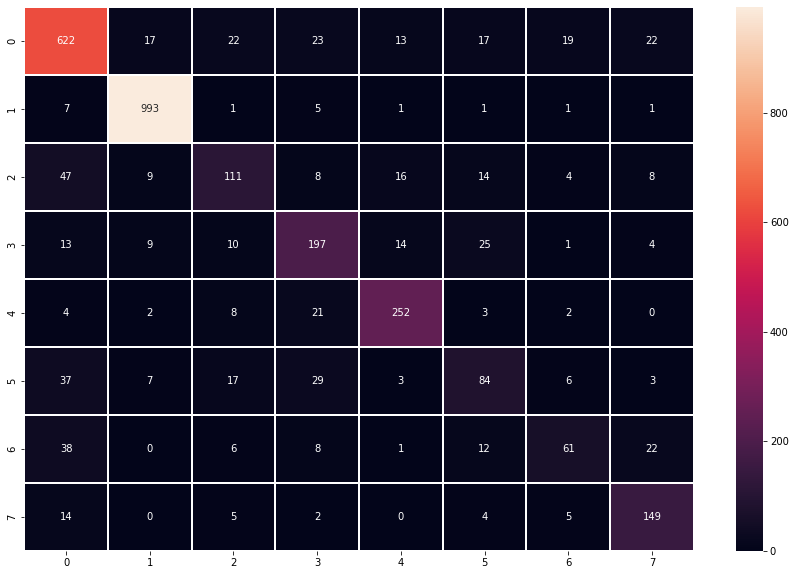

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

In [ ]:
# deberta

In [ ]:
print('F1 Score : {}'.format(f1_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))

F1 Score : 0.8137254901960784
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       755
           1       0.95      0.99      0.97      1010
           2       0.55      0.66      0.60       217
           3       0.72      0.67      0.70       273
           4       0.82      0.87      0.85       292
           5       0.53      0.56      0.55       186
           6       0.64      0.49      0.55       148
           7       0.74      0.84      0.79       179

    accuracy                           0.81      3060
   macro avg       0.73      0.73      0.73      3060
weighted avg       0.82      0.81      0.81      3060



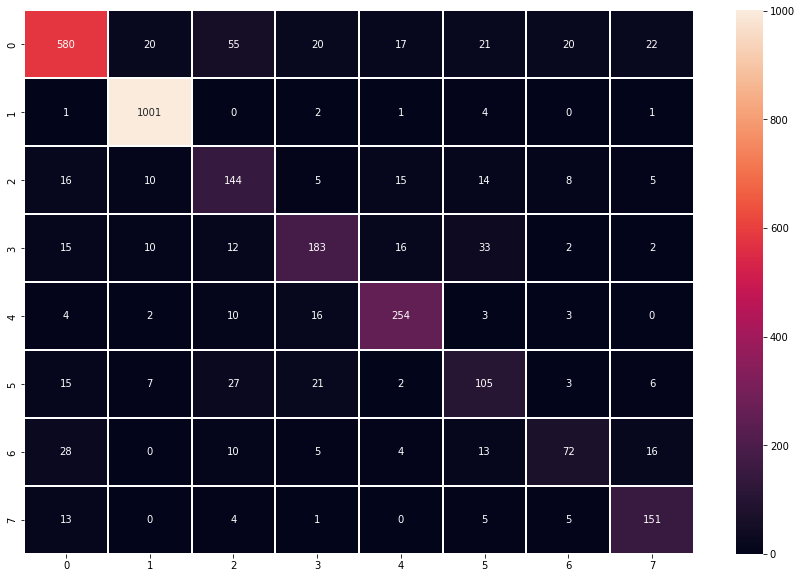

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

# tensorflow model

In [ ]:
! pip install transformers -q

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(f'TF version: {tf.__version__}')
from tensorflow.keras import layers
import transformers

TF version: 2.9.2


In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)

In [ ]:
df = pd.read_csv('https://github.com/naamiinepal/covid-tweet-classification/blob/main/training/datasets/nepali_tweets_dataset_labelled_tweets_feb_23.csv?raw=true')
display(df.head())
print('\n---------DataFrame Summary---------')
df.info()

text  covid_stats  \
0     चितवनमा ९३ हजार बढीले लगाए कोरोनाविरुद्धको खोप            0   
1  जोरबिजोर भनेको गाडी संख्या धेरै भएर ट्राफिक जा...            0   
2  ३१ सय ८ जना संक्रमित थपिदा १५ सय ९५ जना डिस्चा...            1   
3  कोरोनाको जोखिम बढ्दै: झापाको दमक फेरी १ हफ्ता ...            0   
4  कोरोना खोप राज्यले निःशुल्क लगाइरहेकै छ र थप ल...            0   

   vaccination  covid_politics  humour  lockdown  civic_views  \
0            1               0       0         0            0   
1            0               0       0         0            1   
2            0               0       0         0            0   
3            0               0       0         1            0   
4            1               0       0         0            1   

   life_during_pandemic  covid_waves_and_variants  
0                     0                         1  
1                     0                         0  
2                     0                         0  
3                     0                         0  
4                     0                         0


---------DataFrame Summary---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12241 entries, 0 to 12240
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   text                      12241 non-null  object
 1   covid_stats               12241 non-null  int64 
 2   vaccination               12241 non-null  int64 
 3   covid_politics            12241 non-null  int64 
 4   humour                    12241 non-null  int64 
 5   lockdown                  12241 non-null  int64 
 6   civic_views               12241 non-null  int64 
 7   life_during_pandemic      12241 non-null  int64 
 8   covid_waves_and_variants  12241 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 860.8+ KB


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f'Training examples: {len(train_df)}, validation examples: {len(val_df)}')

Training examples: 9792, validation examples: 2449


In [ ]:
TARGET_COLS = ['covid_stats', 'vaccination', 'covid_politics', 'humour', 'lockdown', 'civic_views','life_during_pandemic','covid_waves_and_variants']

MAX_LENGTH = 512
BATCH_SIZE = 8
BERT_MODEL = "NepBERTa/NepBERTa"

In [ ]:
class BertDataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        text,
        labels,
        batch_size=BATCH_SIZE,
        shuffle=True,
        include_targets=True,
    ):
        self.text = text
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            BERT_MODEL, do_lower_case=True
        )
        self.indexes = np.arange(len(self.text))
        self.on_epoch_end()

    def __len__(self):
        return len(self.text) // self.batch_size

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_texts = self.text[indexes]

        encoded = self.tokenizer.batch_encode_plus(
            batch_texts.tolist(),
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="tf",
            truncation=True,
            padding='max_length'
        )

        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="float32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [ ]:
train_data = BertDataGenerator(
    train_df["text"].values.astype("str"),
    np.array(train_df[TARGET_COLS]),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
valid_data = BertDataGenerator(
    val_df["text"].values.astype("str"),
    np.array(val_df[TARGET_COLS]),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
inputs, labels = next(iter(train_data))
print(f'input_ids:\n{inputs[0]} \n With shape {inputs[0].shape} and dtype {inputs[0].dtype}\n')
print(f'attention_mask:\n{inputs[1]} \n With shape {inputs[1].shape} and dtype {inputs[0].dtype}\n')
print(f'token_type_ids:\n{inputs[2]} \n With shape {inputs[2].shape} and dtype {inputs[0].dtype}\n')
print(f'Labels:\n{labels} \n With shape {labels.shape} and dtype {labels.dtype}')

input_ids:
[[    0  3400  2421 ...     1     1     1]
 [    0  2221  2175 ...     1     1     1]
 [    0  6411  4101 ...     1     1     1]
 ...
 [    0  2175 25274 ...     1     1     1]
 [    0  4229  1010 ...     1     1     1]
 [    0  3687  1026 ...     1     1     1]] 
 With shape (8, 512) and dtype int32

attention_mask:
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]] 
 With shape (8, 512) and dtype int32

token_type_ids:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
 With shape (8, 512) and dtype int32

Labels:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]] 
 With shape (8, 8) and dtype float32


In [ ]:
def get_model():
    input_ids = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids"
    )

    attention_masks = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_masks"
    )

    token_type_ids = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), dtype=tf.int32, name="token_type_ids"
    )

    bert_model = transformers.TFBertModel.from_pretrained(BERT_MODEL)
    bert_model.trainable = True

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    cls_output = bert_output.last_hidden_state[:, 0, :]
    output = layers.Dense(8)(cls_output)
    model = tf.keras.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output)

    return model


optimizer=tf.optimizers.Adam(learning_rate=5e-5)





In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 24.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
def get_loss_metrics():
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = [
        tf.metrics.BinaryAccuracy(),
        tfa.metrics.F1Score(num_classes=8, average="weighted", threshold=0.5),
        tf.keras.metrics.AUC(
            2449,
            curve="PR",
            multi_label=True,
            num_labels=8,
            from_logits=True,
        ),
    ]

    return loss, metrics

In [ ]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Some layers from the model checkpoint at NepBERTa/NepBERTa were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at NepBERTa/NepBERTa and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
loss, metrics = get_loss_metrics()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5


1224/1224 [==============================] - 1299s 1s/step - loss: 0.2240 - binary_accuracy: 0.9041 - f1_score: 0.6557 - auc: 0.7494 - val_loss: 0.2109 - val_binary_accuracy: 0.9114 - val_f1_score: 0.6737 - val_auc: 0.8044
Epoch 2/5
1224/1224 [==============================] - 1277s 1s/step - loss: 0.1700 - binary_accuracy: 0.9272 - f1_score: 0.7646 - auc: 0.8348 - val_loss: 0.1922 - val_binary_accuracy: 0.9201 - val_f1_score: 0.7248 - val_auc: 0.8367
Epoch 3/5
1224/1224 [==============================] - 1276s 1s/step - loss: 0.1531 - binary_accuracy: 0.9363 - f1_score: 0.8033 - auc: 0.8692 - val_loss: 0.1994 - val_binary_accuracy: 0.9152 - val_f1_score: 0.7088 - val_auc: 0.8284
Epoch 4/5
1224/1224 [==============================] - 1276s 1s/step - loss: 0.1268 - binary_accuracy: 0.9476 - f1_score: 0.8442 - auc: 0.9071 - val_loss: 0.1939 - val_binary_accuracy: 0.9287 - val_f1_score: 0.7901 - val_auc: 0.8386
Epoch 5/5
 275/1224 [=====>........................] - ETA: 15:09 - loss: 0.09

In [ ]:
pred = model.predict(valid_data)
pred[:5]

306/306 [==============================] - 111s 340ms/step


array([[-2.1905882 , -3.2394354 , -3.13258   , -2.1132884 , -2.4265406 ,
        -0.6075255 , -1.2629524 , -1.5562562 ],
       [-3.583075  ,  2.5596383 ,  0.3140234 , -5.727357  , -5.440543  ,
        -5.8377833 , -5.9488435 , -3.1575963 ],
       [-5.6693244 ,  2.5711992 ,  0.31066525, -4.5653663 , -4.1973977 ,
        -2.9523754 , -4.2711267 , -4.5014157 ],
       [-6.0214763 ,  2.1736732 , -0.54616076, -3.678521  , -3.931436  ,
        -5.0702376 , -2.831023  , -2.5294201 ],
       [-5.866425  ,  1.5135366 , -1.4845128 , -1.75077   , -2.6480722 ,
        -0.91907746, -2.4754624 , -2.8797846 ]], dtype=float32)

In [ ]:
valid_data.labels

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

PreTrainedTokenizer(name_or_path='NepBERTa/NepBERTa', vocab_size=30523, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
model.predict(valid_data.text)

ValueError: ignored

# multi label Bert type model finetuning

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 5.5 MB 13.8 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 
     |████████████████████████████████| 7.6 MB 47.6 MB/s 


In [1]:
import os
import re
import string
import json
import numpy as np
import pandas as pd
from sklearn import metrics

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/merged_data.csv')
df = df.dropna()
df = df.reset_index(drop=True)
display(df.head())

Text  Category
0  बिहार मे होबय वाला नगर निगम \nचुनाव 2022 के नव...  Politics
1  राज्य मे भूमि सँ जुड़ल भ्रष्टाचार \nकेर मामिला ...  Politics
2  गांधीनगर | राष्ट्रीय एकता दिवस पर \nसोम दिन गु...  Politics
3  गुजरात केर मोरबी मे रवि दिन सांझ भेल दर्दनाक द...  Politics
4  गुजरातक मोरबी\nकेर उक्त झुलैत पुल \nलगभग 150 स...  Politics

In [29]:
# Create one-hot encoding for 'Category' with column names as unique values
df_one_hot = pd.get_dummies(df['Category'])
df_one_hot

Culture  Economy  EduTech  Entertainment  Health  Interview  \
0            0        0        0              0       0          0   
1            0        0        0              0       0          0   
2            0        0        0              0       0          0   
3            0        0        0              0       0          0   
4            0        0        0              0       0          0   
...        ...      ...      ...            ...     ...        ...   
15465        0        1        0              0       0          0   
15466        0        1        0              0       0          0   
15467        0        1        0              0       0          0   
15468        0        1        0              0       0          0   
15469        0        1        0              0       0          0   

       Literature  Opinion  Politics  Sports  
0               0        0         1       0  
1               0        0         1       0  
2               0        0         1       0  
3               0        0         1       0  
4               0        0         1       0  
...           ...      ...       ...     ...  
15465           0        0         0       0  
15466           0        0         0       0  
15467           0        0         0       0  
15468           0        0         0       0  
15469           0        0         0       0  

[15470 rows x 10 columns]

In [30]:
# Concatenate one-hot encoding with the original DataFrame
df = pd.concat([df, df_one_hot], axis=1)

In [31]:
df.head()

Text  Category  Culture  \
0  बिहार मे होबय वाला नगर निगम \nचुनाव 2022 के नव...  Politics        0   
1  राज्य मे भूमि सँ जुड़ल भ्रष्टाचार \nकेर मामिला ...  Politics        0   
2  गांधीनगर | राष्ट्रीय एकता दिवस पर \nसोम दिन गु...  Politics        0   
3  गुजरात केर मोरबी मे रवि दिन सांझ भेल दर्दनाक द...  Politics        0   
4  गुजरातक मोरबी\nकेर उक्त झुलैत पुल \nलगभग 150 स...  Politics        0   

   Economy  EduTech  Entertainment  Health  Interview  Literature  Opinion  \
0        0        0              0       0          0           0        0   
1        0        0              0       0          0           0        0   
2        0        0              0       0          0           0        0   
3        0        0              0       0          0           0        0   
4        0        0              0       0          0           0        0   

   Politics  Sports  
0         1       0  
1         1       0  
2         1       0  
3         1       0  
4         1       0

In [32]:
from sklearn.model_selection import train_test_split
df_train, df_dev = train_test_split(df, test_size=0.2, random_state=42)
print(f'Training examples: {len(df_train)}, validation examples: {len(df_dev)}')

Training examples: 12376, validation examples: 3094


In [33]:
df_train =  df_train.reset_index()
df_train

index                                               Text    Category  \
0      14374  पवन.- कार्टून मे उत्‍तराधिकारी सन कोनो चीज नहि...   Interview   
1      14492  उत्तर – संगीत क विधिवत शिक्षा हम उस्ताद जौहर अ...   Interview   
2       9144  3- बाल शिक्षासँ वंचित- परिवार में आर्थिक स्थित...  Literature   
3       3268  एहिमे हिज्जेक गडबडी, शब्दक अशुद्धि, तकनीकी जे ...     Culture   
4       2664  आ दोसर, जेना कि कतहु पढ़नहुँ छी जे पृथ्वी पर कत...     Culture   
...      ...                                                ...         ...   
12371   5191  राम जानकी विवाहपञ्चमी महोत्सव विशेषः अन्तिम वि...     Culture   
12372  13418  "दर्शन,– प्रवीण नारायण चौधरी,चलैत चलू – बढैत च...     Opinion   
12373   5390  जिला विधिक सेवा प्राधिकरण के \nतत्वावधान में म...     Culture   
12374    860  वार्ड नं.२के मतगणना जारी छै । तथापि आएल मतगणना...    Politics   
12375   7270  क्रिस्टियन रेसल रॉयलडो रोनाल्डो आरू अल्वारो मड...      Sports   

       Culture  Economy  EduTech  Entertainment  Health  Interview  \
0            0        0        0              0       0          1   
1            0        0        0              0       0          1   
2            0        0        0              0       0          0   
3            1        0        0              0       0          0   
4            1        0        0              0       0          0   
...        ...      ...      ...            ...     ...        ...   
12371        1        0        0              0       0          0   
12372        0        0        0              0       0          0   
12373        1        0        0              0       0          0   
12374        0        0        0              0       0          0   
12375        0        0        0              0       0          0   

       Literature  Opinion  Politics  Sports  
0               0        0         0       0  
1               0        0         0       0  
2               1        0         0       0  
3               0        0         0       0  
4               0        0         0       0  
...           ...      ...       ...     ...  
12371           0        0         0       0  
12372           0        1         0       0  
12373           0        0         0       0  
12374           0        0         1       0  
12375           0        0         0       1  

[12376 rows x 13 columns]

In [34]:
df_dev =  df_dev.reset_index()
df_dev

index                                               Text  Category  \
0      2519  ‘‘ देशमे अस्थिरता अशान्ति मचाबके काज नीयोजित र...  Politics   
1      6025  । एजेंसी डेप्टो २०। रविवार क॑ बेन स्टोक्स न॑ द...    Sports   
2      6366  । काठमांडू उपाध्यक्ष न्द बहादुर राज पसांग बैंग...    Sports   
3      6962  । अक्टूबर के बाहर काठमांडू।नेपाली केरऽ कप्तान ...    Sports   
4     13347  "तुलसी कृपा रघुबंसमनि की लोह लै लौका तिरा॥"","...   Opinion   
...     ...                                                ...       ...   
3089  13860  "बुद्धौ शरणमन्विच्छ कृपणाः फलहेतवः ॥४९॥"",एहि ...   Opinion   
3090  12897  प्रश्न मैथिली भाषाक संरक्षणक अछि, प्रश्न नव रा...   EduTech   
3091   5066  व्यक्तित्व परिचय एवं साक्षात्कार,– प्रवीण नारा...   Culture   
3092   3975  "मोहन भारद्वाज, मधुबनी। फरबरी १९, २०१७. मैथिली...   Culture   
3093   3433  "धरान, १६ दिसम्बर २०१८. मैथिली जिन्दाबाद!!","क...   Culture   

      Culture  Economy  EduTech  Entertainment  Health  Interview  Literature  \
0           0        0        0              0       0          0           0   
1           0        0        0              0       0          0           0   
2           0        0        0              0       0          0           0   
3           0        0        0              0       0          0           0   
4           0        0        0              0       0          0           0   
...       ...      ...      ...            ...     ...        ...         ...   
3089        0        0        0              0       0          0           0   
3090        0        0        1              0       0          0           0   
3091        1        0        0              0       0          0           0   
3092        1        0        0              0       0          0           0   
3093        1        0        0              0       0          0           0   

      Opinion  Politics  Sports  
0           0         1       0  
1           0         0       1  
2           0         0       1  
3           0         0       1  
4           1         0       0  
...       ...       ...     ...  
3089        1         0       0  
3090        0         0       0  
3091        0         0       0  
3092        0         0       0  
3093        0         0       0  

[3094 rows x 13 columns]

In [35]:
print(df_train.shape)
print(df_dev.shape)

(12376, 13)
(3094, 13)


In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [37]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 5e-5
tokenizer = AutoTokenizer.from_pretrained('NepBERTa/NepBERTa')

In [38]:
df['Category'].unique()

array(['Politics', 'Culture', 'Sports', 'Literature', 'Entertainment',
       'Health', 'EduTech', 'Opinion', 'Interview', 'Economy'],
      dtype=object)

In [39]:
target_cols = ['Politics', 'Culture', 'Sports', 'Literature', 'Entertainment',
       'Health', 'EduTech', 'Opinion', 'Interview', 'Economy']
target_cols

['Politics',
 'Culture',
 'Sports',
 'Literature',
 'Entertainment',
 'Health',
 'EduTech',
 'Opinion',
 'Interview',
 'Economy']

In [40]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [41]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_dev, tokenizer, MAX_LEN)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

In [43]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('NepBERTa/NepBERTa', from_tf = True)
        self.l2 = torch.nn.Dropout(0.5)
        self.fc = torch.nn.Linear(768,10)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(features)
        output = self.fc(output_2)
        return output

model = BERTClass()
model.to(device);

All TF 2.0 model weights were used when initializing BertModel.

All the weights of BertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


In [44]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [45]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [46]:
scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader) * EPOCHS
            )

In [47]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [48]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    outputs, targets = validation()
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print('\n')


In [49]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.11394881457090378
Accuracy Score = 0.7133160956690369
F1 Score (Micro) = 0.7708697170799861
F1 Score (Macro) = 0.6620882447650736


Epoch: 1, Loss:  0.056467846035957336
Accuracy Score = 0.7957336780866192
F1 Score (Micro) = 0.8271004527922188
F1 Score (Macro) = 0.7777480100592717


Epoch: 2, Loss:  0.07918363064527512
Accuracy Score = 0.8190045248868778
F1 Score (Micro) = 0.8407622203811101
F1 Score (Macro) = 0.8112309453618414


Epoch: 3, Loss:  0.054994549602270126
Accuracy Score = 0.8361344537815126
F1 Score (Micro) = 0.853991769547325
F1 Score (Macro) = 0.8326270924585992




Epoch: 0, Loss:  0.11774052679538727
Accuracy Score = 0.8387201034259858
F1 Score (Micro) = 0.8543307086614174
F1 Score (Macro) = 0.8331537892778929




In [57]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.8387201034259858
F1 Score (Micro) = 0.8543307086614174
F1 Score (Macro) = 0.8331537892778929
F1 Score (Weighted) = 0.8537167986623573


In [58]:
print(metrics.f1_score(outputs[:,0],np.array(targets)[:,0]),'\n',
metrics.f1_score(outputs[:,1],np.array(targets)[:,1]),'\n',
metrics.f1_score(outputs[:,2],np.array(targets)[:,2]),'\n',
metrics.f1_score(outputs[:,3],np.array(targets)[:,3]),'\n',
metrics.f1_score(outputs[:,4],np.array(targets)[:,4]),'\n',
metrics.f1_score(outputs[:,5],np.array(targets)[:,5]),'\n',
metrics.f1_score(outputs[:,6],np.array(targets)[:,6]),'\n',
metrics.f1_score(outputs[:,7],np.array(targets)[:,7]),'\n',
metrics.f1_score(outputs[:,8],np.array(targets)[:,8]),'\n',
metrics.f1_score(outputs[:,9],np.array(targets)[:,9])
)

0.9073170731707317 
 0.8417721518987341 
 0.9136690647482014 
 0.8557213930348259 
 0.8026607538802661 
 0.7512690355329948 
 0.641025641025641 
 0.9005847953216374 
 0.8383233532934132 
 0.8791946308724832


In [59]:
torch.save(model.state_dict(), 'model.bin')